# Trabalho de casa 02: Regressão linear

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividido em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\boldsymbol{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do minibatch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [61]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)


features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

In [62]:
# Seu código aqui
def linear_regression_PI(X, y):
    """
    Implements a Linear Regression model using the Moore-Penrose pseudo-inverse
    
    Parameters
    ----------
    X : array
        A 2-dimensional array with samples in the rows and features in the columns
    y : array
        An array with the same number of  as samples in X, the values to predict
    
    Returns
    -------
    w : array
        Learnt parameters
        
    Notes
    -----
    The first column of w corresponds to the bias (`w_0`)
    """
    bias = np.ones((len(X),1))
    X = np.concatenate((bias,X),axis=1)
    pseudo_inverse = np.linalg.pinv(X)
    w = np.matmul(pseudo_inverse,y)
    return w


def linear_regression_SGD(X_train, y_train, X_validation, y_validation, lr=1e-7, batch_size = 50, max_iter=10**8, epsilon = 1e-6):
    """
    Implements a Linear Regression model using Stochastic Gradient Descent
    
    Parameters
    ----------
    X_train : array
        A 2-dimensional array with samples in the rows and features in the columns
    y_train : array
        An array with the same number of  as samples in X, the values to predict
    lr : float
        Learning rate
    max_iter : int
        number of epochs to use for the gradient descent
    
    Returns
    -------
    w : array
        Learnt parameters
    sse_history : array
        An array that contains the error of the model in every iteration
    Notes
    -----
    This function uses the gradient of the sum of squares function
    """
    bias = np.ones((len(X_train),1))
    X_train = np.concatenate((bias,X_train),axis=1)
    X_validation = np.concatenate((np.ones((len(X_validation),1)),X_validation),axis=1)
    w=np.random.normal(0,1, size = (X_train.shape[1], 1))
    X_shuffled = X_train.copy()
    y_shuffled = y_train.copy()
    y_shuffled = y_shuffled.reshape(-1,1)
    y_validation = y_validation.reshape(-1,1)
    history =[]
    for i in range(max_iter):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_shuffled[indices]
        y_shuffled = y_shuffled[indices]
        for j in range(0,X_train.shape[0],batch_size):
            X_batch = X_shuffled[j:j+batch_size]
            y_batch = y_shuffled[j:j+batch_size]
            diff = np.matmul(X_batch,w)-y_batch
            gradient = (2/batch_size) * np.matmul(np.transpose(X_batch),diff)
            w1 = w - lr*gradient
            history.append(np.linalg.norm(np.matmul(X_validation,w1)-y_validation)**2/len(y_validation))
            if np.linalg.norm(w1-w)<epsilon:
                w = w1
                break
            w = w1
        else:
            continue
        break
    return w,history


w2 = linear_regression_PI(features_train, labels_train)


In [63]:
import matplotlib.pyplot as plt
import time
w, sse_history = [], []
for j in range(1,10):
    start = time.time()
    w1, sse_history1 = linear_regression_SGD(features_train, labels_train,features_validation, labels_validation, batch_size = 2**j)
    end = time.time()
    print(f'batch size = {2**j}, time = {end-start:.2f}')
    w.append(w1)
    sse_history.append(sse_history1)

batch size = 2, time = 1.37
batch size = 4, time = 7.18
batch size = 8, time = 8.02
batch size = 16, time = 3.46
batch size = 32, time = 4.67
batch size = 64, time = 3.49
batch size = 128, time = 2.00
batch size = 256, time = 2.68
batch size = 512, time = 5.22


OLS loss = 0.54


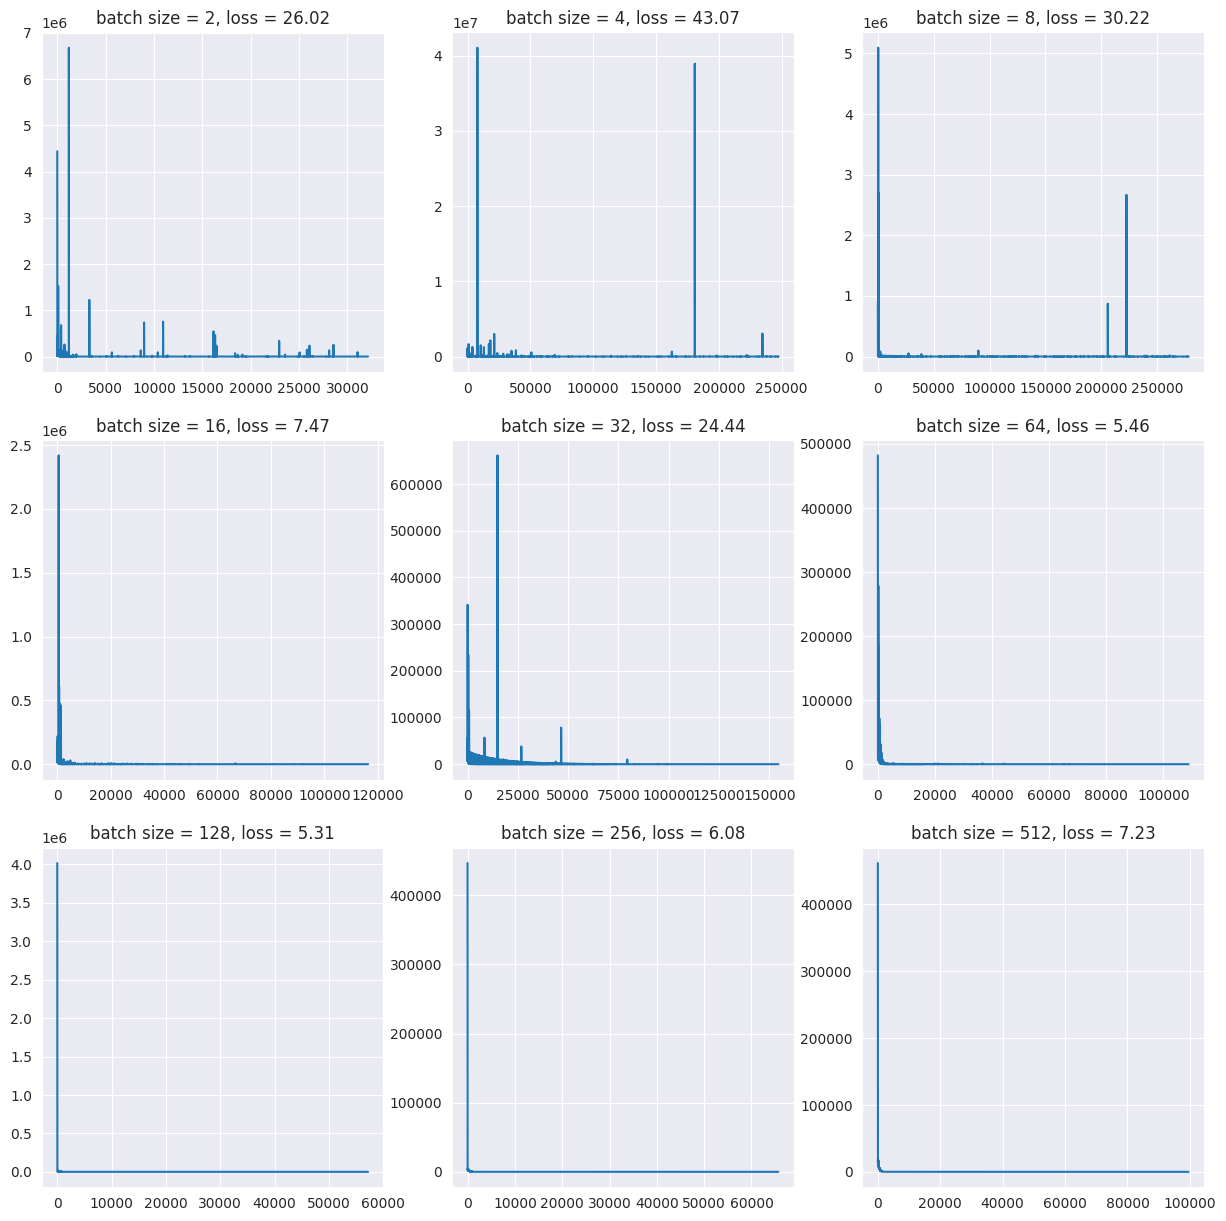

In [68]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for j in range(9):
    axs[j//3, j%3].plot(sse_history[j])
    axs[j//3, j%3].set_title(f'batch size = {2**(j+1)}, loss = {sse_history[j][-1]:.2f}')
ols_loss = np.linalg.norm(np.matmul(np.c_[np.ones(labels_validation.shape),features_validation],w2)-labels_validation)**2/len(labels_validation)
print(f'OLS loss = {ols_loss:.2f}')
plt.show()

Usando os mesmos hiperparâmetros, somente alterando o tamanho do minibatch, podemos ver que o tempo de treinamento não muda muito, sendo uma função principalmente dependente do número de epochs que cada sgd leva para convergir. também não parece haver uma relação clara entre o tamanho do minibatch e a perda final. OLS, por outro lado, leva muito menos tempo para treinar e tem uma perda menor.

**Exercício 2.** Agora, utilizando ainda o mesmo dataset da questão anterior, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [65]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto")

k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]]
)
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

[[10.  2.]
 [ 1.  2.]]


Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.


In [66]:
error_k = []
for k in range(2, 30):
    k_means_model = k_means_factory(n_clusters=k)
    k_means_model.fit(features_train)
    cluster_centers = k_means_model.cluster_centers_
    d_max = np.max(np.linalg.norm(cluster_centers[:,:,np.newaxis]-np.transpose(cluster_centers[:,:,np.newaxis]),axis=1))
    gamma = 1/d_max**2
    feats = np.exp(-gamma*np.linalg.norm(features_train[:,:,np.newaxis]-np.transpose(cluster_centers[:,:,np.newaxis]),axis=1)**2)
    w = linear_regression_PI(feats, labels_train)
    vali = np.exp(-gamma*np.linalg.norm(features_validation[:,:,np.newaxis]-np.transpose(cluster_centers[:,:,np.newaxis]),axis=1)**2)
    vali = np.c_[np.ones(len(vali)),vali]
    error_k.append(np.linalg.norm(np.matmul(vali,w)-labels_validation)**2/len(labels_validation))

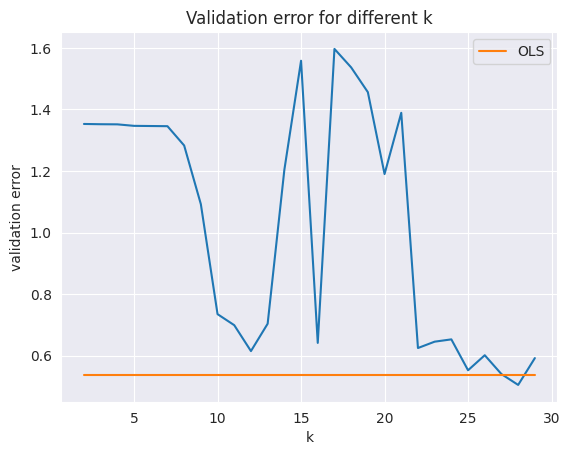

In [73]:
plt.plot(range(2,30),error_k)
plt.plot(range(2,30),ols_loss*np.ones(28),label='OLS')
plt.legend()
plt.xlabel('k')
plt.ylabel('validation error')
plt.title('Validation error for different k')
plt.show()

Podemoes ver que com alguns valores de k o erro se aproxima do valor do erro para o modelo linear simples. Isso indica que o modelo RBF com k igual a esses valores não está trazendo nenhuma vantagem clara em relação ao modelo linear simples.

# Exercícios de "papel e caneta"

**Exercício 1.** Deixe que $X \in \mathbb{R}^{N\times D}$, $c>0$ e $I$ denote a matriz identidade de dimensão $N$.
 Mostre que $X^\intercal X + c I$ possui inversa.

Podemos provar que a matriz $$X^\intercal X + c I$$ é invertível mostrando que $x^\intercal (X^\intercal X + c I)x > 0$ para todo $x\neq 0$.
$$\begin{align}
x^\intercal (X^\intercal X + c I)x &= x^\intercal X^\intercal X x + c x^\intercal x\\
x^\intercal (X^\intercal X + c I)x &= \|Xx\|_2^2 + c\|x\|_2^2
\end{align}$$
Como $\|Xx\|_2^2 \geq 0$ e $\|x\|_2^2 > 0$, temos que $x^\intercal (X^\intercal X + c I)x > 0$ para todo $x\neq 0$. Portanto, $X^\intercal X + c I$ é invertível.


**Exercício 2.** Deixe que $X \in \mathbb{R}^{N\times D}$ seja uma matriz contendo os exemplos de treinamento (um por linha) e que $y\in \mathbb{R}^N$ seja um vetor coluna dos outputs observados para cada vetor de input em suas linhas. Na aula, derivamos a solução de mínimos quadrados ordinários (OLS). Use o mesmo raciocínio para resolver achar o vetor de pesos ${\theta}$ que minimiza:
 
$$ \|X \theta - y\|_2^2 + c \|\theta\|_2^2,$$

onde $c>0$ é uma constante.

queremos achar $\hat{\theta}$ tal que:

$$\begin{align}
\hat{\theta} = argmin_{\theta\in\mathbb{R}^{D+1}}\left\{l(\theta):=\|X \theta - y\|_2^2 + c \|\theta\|_2^2\right\}
\end{align}$$

primeiro vamos expandir a função de custo:

$$ \begin{align}
l(\theta)&=\|X \theta - y\|_2^2 + c \|\theta\|_2^2\\
l(\theta)&=(X \theta - y)^\intercal(X \theta - y)+c\theta^\intercal\theta\\
l(\theta)&=\theta^\intercal X^\intercal X \theta - 2\theta^\intercal X^\intercal y + y^\intercal y + c\theta^\intercal\theta
\end{align}$$

Com a função de custo expandida, podemos derivar em relação a $\theta$ e igualar a zero para achar o mínimo:
$$ \begin{align}
\nabla_\theta l(\theta)&=X^\intercal X \theta -2X^\intercal y + 2c\theta
\end{align}$$
$$\begin{align}
&\nabla_\theta=X^\intercal X \theta -2X^\intercal y + 2c\theta = 0\\
&\implies X^\intercal X \theta + 2c\theta = 2X^\intercal y\\
&\implies (X^\intercal X + 2cI)\theta = 2X^\intercal y\\
&\implies \theta = (X^\intercal X + 2cI)^{-1}2X^\intercal y
\end{align}$$



**Exercício 3.** Em algumas situações, temos muito mais features que amostras ($D \gg N$). Esse tipo de cenário é comum, e.g., na análise de dados genômicos. Nesse caso, costumam existir infinitas combinações lineares das features que expressam o vetor de saídas $y$. Portanto, precisamos de algum critério para escolher um deles. Uma abordagem possível, é escolher o vetor de pesos $\theta$ que possua menor norma L2.
Com isso em mente, derive a solução que minimiza $\|\theta\|_2^2$ e respeita $X \theta = y$. Assuma que as linhas de $X$ são linearmente independentes.

Queremos achar $\hat{\theta}$ tal que:
    $$
    \hat{\theta} =
    \begin{cases}argmin_{\theta\in\mathbb{R}^{D+1}}\left\{\|\theta\|_2^2\right\}\\
    X \theta = y
    \end{cases}
    $$
Podemos encontrar $\hat{\theta}$ resolvendo o problema de otimização com restrição usando multiplicadores de Lagrange:
$$
\mathcal{L}(\theta,\lambda) = \|\theta\|_2^2 + \lambda^\intercal(X\theta - y)
$$
Derivando em relação a $\theta$ e igualando a zero:
$$
\nabla_\theta \mathcal{L}(\theta,\lambda) = 2\theta^\intercal + \lambda^\intercal X = 0
$$
$$
\theta = -\frac{1}{2}X^\intercal\lambda
$$
Derivando em relação a $\lambda$ e igualando a zero:
$$
\nabla_\lambda \mathcal{L}(\theta,\lambda) = X\theta - y = 0
$$
$$
X\theta=y
$$
com isso, temos um novo sistema de equações:
$$
\hat{\theta} =
\begin{cases}
X\theta = y\\
\theta = -\frac{1}{2}X^\intercal \lambda
\end{cases}
$$

Substituindo a segunda equação na primeira:
$$
X(-\frac{1}{2}X^\intercal \lambda) = y
$$
$$
-\frac{1}{2}X X^\intercal \lambda = y
$$
$$
X X^\intercal \lambda = -2y
$$
$$
\lambda = -(X X^\intercal)^{-1}2y
$$
Substituindo $\lambda$ na equação para $\theta$:
$$
\theta = -\frac{1}{2}X^\intercal (-(X X^\intercal)^{-1}2y)
$$
$$
\theta = X^\intercal (X X^\intercal)^{-1}y
$$
Podemos assumir que $(X X^\intercal)^{-1}$ existe, pois as linhas de $X$ são linearmente independentes.